This file is used for patient-level aggregation. Here we use a two-layer full-connected neural network to train and classify the patients' patch-level probability histogram.

In [184]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl import load_workbook
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,f1_score,balanced_accuracy_score
from sklearn import linear_model
from sklearn import svm,decomposition
dataset = load_workbook('D:/dataset_Huo_4/feature/3resnet18/feature_train_10.xlsx',data_only=True)
dataset_x = dataset.active
dataset_test = load_workbook('D:/dataset_Huo_4/feature/3resnet18/feature_test_10.xlsx',data_only=True)
dataset_tst = dataset_test.active
validation = load_workbook('D:/dataset_Huo_4/feature/3resnet18/feature_val_10.xlsx',data_only=True)
val_tst = validation.active

MSI_train_other_info = load_workbook('D:/dataset_Huo_4/MSIMUT_train.xlsx',data_only=True)
MSI_train_other_inf = MSI_train_other_info.active
MSS_train_other_info = load_workbook('D:/dataset_Huo_4/MSS_train.xlsx',data_only=True)
MSS_train_other_inf = MSS_train_other_info.active
MSI_test_other_info = load_workbook('D:/dataset_Huo_4/MSIMUT_test.xlsx',data_only=True)
MSI_test_other_inf = MSI_test_other_info.active
MSS_test_other_info = load_workbook('D:/dataset_Huo_4/MSS_test.xlsx',data_only=True)
MSS_test_other_inf = MSS_test_other_info.active
MSI_val_other_info = load_workbook('D:/dataset_Huo_4/MSIMUT_validation.xlsx',data_only=True)
MSI_val_other_inf = MSI_val_other_info.active
MSS_val_other_info = load_workbook('D:/dataset_Huo_4/MSS_validation.xlsx',data_only=True)
MSS_val_other_inf = MSS_val_other_info.active

In [185]:
train_gender = []
train_age = []
test_gender = []
test_age = []
val_gender = []
val_age = []
for i in range(101):
    train_gender.append(MSS_train_other_inf.cell(2,i+1).value)
    train_age.append(MSS_train_other_inf.cell(3,i+1).value)
for j in range(23):
    train_gender.append(MSI_train_other_inf.cell(2,j+1).value)
    train_age.append(MSI_train_other_inf.cell(3,j+1).value)
for a in range(74):
    test_gender.append(MSS_test_other_inf.cell(2,a+1).value)
    test_age.append(MSS_test_other_inf.cell(3,a+1).value)
for b in range(25):
    test_gender.append(MSI_test_other_inf.cell(2,b+1).value)
    test_age.append(MSI_test_other_inf.cell(3,b+1).value)
for a in range(49):
    val_gender.append(MSS_val_other_inf.cell(2,a+1).value)
    val_age.append(MSS_val_other_inf.cell(3,a+1).value)
for b in range(12):
    val_gender.append(MSI_val_other_inf.cell(2,b+1).value)
    val_age.append(MSI_val_other_inf.cell(3,b+1).value)

In [186]:
train_data = [[0]*13 for i in range(193)]
for i in range(193):
    for j in range(10):
        train_data[i][j] = dataset_x.cell(i+1,j+1).value
    train_data[i][12] = float(dataset_x.cell(i+1,12).value)

for l in range(101):
    train_data[l][10] = train_gender[l]
    train_data[l][11] = train_age[l] / max(train_age)

for l in range(23):
    train_data[l+101][10] = train_gender[l+101]
    train_data[l+101][11] = train_age[l+101] / max(train_age)
    train_data[l+124][10] = train_gender[l+101]
    train_data[l+124][11] = train_age[l+101] / max(train_age)
    train_data[l+147][10] = train_gender[l+101]
    train_data[l+147][11] = train_age[l+101] / max(train_age)
    train_data[l+170][10] = train_gender[l+101]
    train_data[l+170][11] = train_age[l+101] / max(train_age)
train_data = np.array(train_data)
# pca = decomposition.PCA(n_components='mle',whiten=True)
lable = np.arange(193)
# permutation = np.random.permutation(lable.shape[0])
# data_shuffle = train_data[permutation,:]
# print(data_shuffle)
# for m in range(193):
#     print(train_data[m])

In [187]:
X_test = [[0]*12 for i in range(99)]
# y = [[0]*1 for i in range(188)]
y_test = []
for i in range(99):
    for j in range(10):
        X_test[i][j] = dataset_tst.cell(i+1,j+1).value
    X_test[i][10] = test_gender[i]
    X_test[i][11] = test_age[i] / max(test_age)
    y_test.append(float(dataset_tst.cell(i+1,12).value))
# X_test = np.array(X_test)
# X_test = pca.fit_transform(X_test)
# X_test

In [188]:
X_val = [[0]*12 for i in range(61)]
# y_val = [[0]*1 for i in range(61)]
y_val = []
for i in range(61):
    for j in range(10):
        X_val[i][j] = val_tst.cell(i+1,j+1).value
    X_val[i][10] = val_gender[i]
    X_val[i][11] = val_age[i] / max(val_age)
    y_val.append(float(val_tst.cell(i+1,12).value))
# X_val = np.array(X_val)   
# X_val = pca.fit_transform(X_val)
val_msi = 0
val_mss = 0
pred_label_val = []
for j in range(49):
    if val_tst.cell(j+1,11).value < 0.5:
        pred_label_val.append(0)
        val_mss = val_mss + 1
    if val_tst.cell(j+1,11).value >= 0.5:
        pred_label_val.append(1)
        
for i in range(12):
    if val_tst.cell(i+49,11).value < 0.5:
        pred_label_val.append(0)
    if val_tst.cell(i+49,11).value >= 0.5:
        pred_label_val.append(1)
        val_msi = val_msi + 1

In [189]:
X_test = torch.from_numpy(np.array(X_test)).type(torch.FloatTensor)
y_test = torch.from_numpy(np.array(y_test)).type(torch.LongTensor)
X_val = torch.from_numpy(np.array(X_val)).type(torch.FloatTensor)
y_val = torch.from_numpy(np.array(y_val)).type(torch.LongTensor)

In [190]:
true_label = []
for j in range(74):
    true_label.append(0)
for i in range(25):
    true_label.append(1)

In [191]:
true_val_label = []
for j in range(49):
    true_val_label.append(0)
for i in range(12):
    true_val_label.append(1)

In [192]:
val_f1 = f1_score(true_val_label,pred_label_val)
print(val_mss,'/ 49',val_msi,'/ 12')
print(val_f1)

40 / 49 6 / 12
0.4444444444444445


In [193]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(12,15)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(15,2)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        out = self.fc1(x)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc2(out)
        # out = F.softmax(out,dim = 0)
        return out
             
    def predict(self,x):
        pred = F.softmax(self.forward(x),dim = 1)
        # print(pred)
        # pred = self.forward(x)
        ans = []
        # ans.append(pred)
        for i in range(len(pred)):
            # ans.append(pred[i][1] / (pred[i][0] + pred[i][1]))
            ans.append(pred[i][1])
        return torch.tensor(ans)

In [194]:
model = Model()

In [195]:
weight = [0.33,0.67]
weight = torch.tensor(weight)
criterion = nn.CrossEntropyLoss(weight)  #交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Adam梯度优化器

In [196]:
# model.load_state_dict(torch.load('D:/dataset_Huo_1/pretrained.pth'))
print(val_f1)
epoch = 8000
epochs = []
losses = []
score_list = []    
val_right_mss = []
val_right_msi = []
for i in range(epoch):
    mss = 0
    msi = 0
    #shuffle操作
    X = [[0]*12 for i in range(193)]
    y = []
    permutation = np.random.permutation(lable.shape[0])
    data_shuffle = train_data[permutation,:]
    for j in range(193):
        for m in range(10):
            X[j][m] = data_shuffle[j][m]
        y.append(data_shuffle[j][10])
    X = torch.from_numpy(np.array(X)).type(torch.FloatTensor)
    y = torch.from_numpy(np.array(y)).type(torch.LongTensor)
    #此epoch的shuffle结束
     
    model.train()
    val_label = []
    y_pred = model.forward(X)
    loss = criterion(y_pred,y)
    losses.append(loss.item())
    epochs.append(i)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()#训练过程

    with torch.no_grad():
        model.eval()
        pred_val = model.predict(X_val)
    pred_val = np.array(pred_val)
    for j in range(len(pred_val)):
        if pred_val[j] < 0.5:
            val_label.append(0)
        else:
            val_label.append(1)
    for m in range(49):
        if val_label[m] == 0:
            mss+=1
    for b in range(12):
        if val_label[b+49] == 1:
            msi+=1
    val_right_mss.append(mss)
    val_right_msi.append(msi)
    f1 = f1_score(true_val_label,val_label)
    # balanced_acc = balanced_accuracy_score(true_val_label,val_label)
    print(i,'loss:',loss.item(),'score:',f1)
    score_list.append(f1)
    path = 'D:/dataset_Huo_4/method3_buf/checkpoint' + str(i) + '.pth'
    torch.save(model.state_dict(),path)
max_score = score_list[score_list.index(max(score_list))]
# print('index of max checkpoint:',max_id)
print('original val f1 score',val_f1)
print('max score:',max_score)



0.4444444444444445
0 loss: 0.829138457775116 score: 0.0
1 loss: 0.8298307061195374 score: 0.0
2 loss: 0.8282074332237244 score: 0.0
3 loss: 0.8252363801002502 score: 0.0
4 loss: 0.8240045309066772 score: 0.0
5 loss: 0.8184458017349243 score: 0.0
6 loss: 0.820477306842804 score: 0.0
7 loss: 0.8161993026733398 score: 0.0
8 loss: 0.8176508545875549 score: 0.0
9 loss: 0.8127326965332031 score: 0.0
10 loss: 0.8066703081130981 score: 0.0
11 loss: 0.8026506304740906 score: 0.0
12 loss: 0.802241861820221 score: 0.0
13 loss: 0.802213191986084 score: 0.0
14 loss: 0.8031890988349915 score: 0.0
15 loss: 0.8010540008544922 score: 0.0
16 loss: 0.7950176000595093 score: 0.0
17 loss: 0.7934005856513977 score: 0.0
18 loss: 0.792149543762207 score: 0.0
19 loss: 0.7890357971191406 score: 0.0
20 loss: 0.784652590751648 score: 0.0
21 loss: 0.7831031084060669 score: 0.0
22 loss: 0.7799912095069885 score: 0.0
23 loss: 0.7799374461174011 score: 0.0
24 loss: 0.7779779434204102 score: 0.0
25 loss: 0.77773463726

In [197]:
max_index = [i for i,x in enumerate(score_list) if x == max_score]
bacc_select_list = []
print('number:',len(max_index))
for p in range(len(max_index)):
    path = 'D:/dataset_Huo_4/method3_buf/checkpoint' + str(max_index[p]) + '.pth'
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint)
    model.eval()
    np.set_printoptions(suppress=True)
    pred = model.predict(X_val)
    pred = np.array(pred)
    pred_label = []
    for i in range(61):
        if pred[i] < 0.5:
            pred_label.append(0)
        else:
            pred_label.append(1)
    y_val = np.array(y_val)
    bacc_of_it = balanced_accuracy_score(y_val,pred_label)
    # f1_score_it = f1_score(y_test,pred_label)
    # balanced_acc_it = balanced_accuracy_score(y_test,pred_label)
    bacc_select_list.append(bacc_of_it)
    print(max_index[p],bacc_of_it)
max_bacc = max(bacc_select_list)
max_bacc_index = [x for i,x in enumerate(max_index) if bacc_select_list[i] == max_bacc]


number: 6
88 0.5102040816326531
568 0.5102040816326531
569 0.5102040816326531
570 0.5102040816326531
578 0.5102040816326531
579 0.5102040816326531


In [198]:
auc_select_list = []
print('number:',len(max_bacc_index))
for p in range(len(max_bacc_index)):
    path = 'D:/dataset_Huo_4/method3_buf/checkpoint' + str(max_bacc_index[p]) + '.pth'
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint)
    model.eval()
    np.set_printoptions(suppress=True)
    pred = model.predict(X_val)
    pred = np.array(pred)
    pred_label = []
    for i in range(61):
        if pred[i] < 0.5:
            pred_label.append(0)
        else:
            pred_label.append(1)
    y_val = np.array(y_val)
    auc_of_it = roc_auc_score(y_val,pred)
    # f1_score_it = f1_score(y_test,pred_label)
    # balanced_acc_it = balanced_accuracy_score(y_test,pred_label)
    auc_select_list.append(auc_of_it)
    print(max_bacc_index[p],auc_of_it)
max_auc = max(auc_select_list)
max_auc_index = [x for i,x in enumerate(max_bacc_index) if auc_select_list[i] == max_auc]
print(val_right_mss[max_auc_index[0]],'/ 49',val_right_msi[max_auc_index[0]],'/ 12')

number: 6
88 0.47789115646258495
568 0.3537414965986394
569 0.3537414965986394
570 0.3537414965986394
578 0.3537414965986394
579 0.3537414965986394
1 / 49 12 / 12


In [199]:
max_id = max_auc_index[0]
print('max_id',max_id)
max_path = 'D:/dataset_Huo_4/method3_buf/checkpoint' + str(max_id) + '.pth'
# max_path = 'D:/dataset_Huo_4/method4_output/mobilenet_checkpoint.pth'
checkpoint = torch.load(max_path)
# model = Model()

# checkpoint = torch.load('D:/dataset_Huo_1/method4_output/resnet18_checkpoint323.pth')
model.load_state_dict(checkpoint)

model.eval()
# print(accuracy_score(model.predict(X_test),y_test))
np.set_printoptions(suppress=True)
pred = model.predict(X_test)
pred = np.array(pred)
# pred =  model.predict(X_test)
pred_label = []
for i in range(99):
    if pred[i] < 0.5:
        pred_label.append(0)
    else:
        pred_label.append(1)
y_test = np.array(y_test)
# print(pred_label)
print('AUC:',roc_auc_score(y_test,pred))
print('f1:',f1_score(y_test,pred_label))
print('balanced_acc:',balanced_accuracy_score(y_test,pred_label))
right_mss = 0
right_msi = 0
for k in range(74):
    if pred_label[k] == 0:
        right_mss = right_mss + 1
for k in range(25):
    if pred_label[k + 74] == 1:
        right_msi = right_msi + 1
print('right mss:',right_mss,'/ 74')
print('right msi:',right_msi,'/ 25')
print('acc:', right_mss + right_msi,'/ 99')
print('acc:', (right_mss + right_msi) / 99)

max_id 88
AUC: 0.4416216216216216
f1: 0.40983606557377045
balanced_acc: 0.5135135135135135
right mss: 2 / 74
right msi: 25 / 25
acc: 27 / 99
acc: 0.2727272727272727


In [200]:
print(sum(pred[0:74])/74)
print(sum(pred[74:99])/25)

0.5341839552731127
0.527404568195343


In [201]:
true_label = []
for j in range(74):
    true_label.append(0)
for i in range(25):
    true_label.append(1)
auc_score1 = roc_auc_score(true_label,pred)
print(auc_score1)
# print(auc_score1 - 0.7952182952182952) # resnet18
# print(auc_score1 - 0.7406444906444907) # mobilenetv2_0905
# print(auc_score1 - 0.7156964656964657) # mobilenetv2
# print(auc_score1 - 0.7661122661122661) # efficientnetb4
# print(auc_score1 - 0.804054054054054)  # dpn131
# print(auc_score1 - 0.7110187110187111) # resnext101

0.4416216216216216


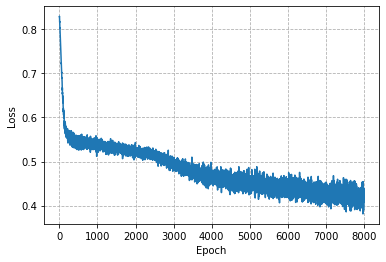

In [202]:
plt.plot(epochs,losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(ls='--')  # 生成网格
plt.show()